In [ ]:
%load_ext autoreload
%autoreload 2

import odc.stac
import pandas as pd
import pystac_client

from pyTMD.compute import tide_elevations
import pandas as pd
import numpy as np


GAUGE_X = 122.2183
GAUGE_Y = -18.0008
ENSEMBLE_MODELS = ["EOT20", "HAMTIDE11"]  # simplified for tests

## Load fixtures

In [4]:
def load_satellite_ds():
    """
    Load a sample timeseries of Landsat 8 data using odc-stac
    """
    # Connect to stac catalogue
    catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

    # Set cloud defaults
    odc.stac.configure_rio(
        cloud_defaults=True,
        aws={"aws_unsigned": True},
    )

    # Build a query with the parameters above
    buffer = 0.08
    # buffer = 0.5
    bbox = [GAUGE_X - buffer, GAUGE_Y - buffer, GAUGE_X + buffer, GAUGE_Y + buffer]
    query = catalog.search(
        bbox=bbox,
        collections=["ga_ls8c_ard_3"],
        datetime="2020-01/2020-02",
    )

    # Search the STAC catalog for all items matching the query
    ds = odc.stac.load(
        list(query.items()),
        bands=["nbart_red"],
        crs="epsg:3577",
        resolution=30,
        groupby="solar_day",
        bbox=bbox,
        fail_on_error=False,
        chunks={},
    )

    return ds

satellite_ds = load_satellite_ds()

def load_measured_tides_ds():
    """
    Load measured sea level data from the Broome ABSLMP tidal station:
    http://www.bom.gov.au/oceanography/projects/abslmp/data/data.shtml
    """
    # Metadata for Broome ABSLMP tidal station:
    # http://www.bom.gov.au/oceanography/projects/abslmp/data/data.shtml
    ahd_offset = -5.322

    # Load measured tides from ABSLMP tide gauge data
    measured_tides_df = pd.read_csv(
        "../tests/data/IDO71013_2020.csv",
        index_col=0,
        parse_dates=True,
        na_values=-9999,
    )[["Sea Level"]]

    # Update index and column names
    measured_tides_df.index.name = "time"
    measured_tides_df.columns = ["tide_height"]

    # Apply station AHD offset
    measured_tides_df += ahd_offset

    # Return as xarray dataset
    return measured_tides_df.to_xarray()

satellite_ds = load_satellite_ds()
measured_tides_ds = load_measured_tides_ds()

## Testing pyTMD

In [ ]:
from eo_tides import model_tides

x, y, crs, method, model = GAUGE_X, GAUGE_Y, "EPSG:4326", "spline", "EOT20"
x, y, crs, method, model = GAUGE_X, GAUGE_Y, "EPSG:4326", "bilinear", "EOT20"
x, y, crs, method, model = -1034913, -1961916, "EPSG:3577", "bilinear", "EOT20"


# Run EOT20 tidal model for locations and timesteps in tide gauge data
modelled_tides_df = model_tides(
    x=[x],
    y=[y],
    time=measured_tides_ds.time,
    crs=crs,
    method=method,
    directory="../tests/data/tide_models",
)

# Run equivalent pyTMD code to verify same results
pytmd_tides = tide_elevations(
        x=x, 
        y=y, 
        delta_time=measured_tides_ds.time,
        DIRECTORY="../tests/data/tide_models",
        MODEL="EOT20",
        EPSG=int(crs[-4:]),
        TIME="datetime",
        EXTRAPOLATE=True,
        CUTOFF=np.inf,
        METHOD=method,
        # CORRECTIONS: str | None = None,
        # INFER_MINOR: bool = True,
        # MINOR_CONSTITUENTS: list | None = None,
        # APPLY_FLEXURE: bool = False,
        # FILL_VALUE: float = np.nan
        )

np.allclose(modelled_tides_df.tide_height.values, pytmd_tides.data)

### Error for out of bounds

In [10]:
from eo_tides import model_tides

x, y = 180, -50


# Run EOT20 tidal model for locations and timesteps in tide gauge data
modelled_tides_df = model_tides(
    x=[x],
    y=[y],
    model=["EOT20", "GOT5.5"],
    time=measured_tides_ds.time,
    directory="../tests/data/tide_models",
)

### Modelling ebb and flow tidal phases
The `tag_tides` function also allows us to determine whether each satellite observation was taken while the tide was rising/incoming (flow tide) or falling/outgoing (ebb tide) by setting `ebb_flow=True`. This is achieved by comparing tide heights 15 minutes before and after the observed satellite observation.

Ebb and flow data can provide valuable contextual information for interpreting satellite imagery, particularly in tidal flat or mangrove forest environments where water may remain in the landscape for considerable time after the tidal peak.

Once you run the cell below, our data will now also contain a new `ebb_flow` variable under **Data variables**:

In [ ]:
# Model tide heights
ds = tag_tides(
    ds, 
    ebb_flow=True,     
    directory="../../tests/data/tide_models",
)

# Print output data
print(ds)

We now have data giving us the both the tide height and tidal phase ("ebb" or "flow") for every satellite image:

In [ ]:
ds[["time", "tide_height", "ebb_flow"]].drop_vars("spatial_ref").to_dataframe().head()

We could for example use this data to filter our observations to keep ebbing phase observations only:

In [ ]:
ds_ebb = ds.where(ds.ebb_flow == "Ebb", drop=True)
print(ds_ebb)

## Pixel biases

In [1]:
import odc.stac
import pystac_client
import planetary_computer

# Connect to STAC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set cloud access defaults
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

# Build a query and search the STAC catalog for all matching items
bbox = [122.160, -18.05, 122.260, -17.95]
query = catalog.search(
    bbox=bbox,
    collections=["sentinel-2-l2a"],
    datetime="2021/2023",
)

# Load data into xarray format
ds_s2 = odc.stac.load(
    items=list(query.items()),
    bands=["red"],
    crs="utm",
    resolution=30,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

print(ds_s2)

<xarray.Dataset> Size: 111MB
Dimensions:      (y: 371, x: 356, time: 211)
Coordinates:
  * y            (y) float64 3kB 8.015e+06 8.015e+06 ... 8.004e+06 8.004e+06
  * x            (x) float64 3kB 4.11e+05 4.111e+05 ... 4.217e+05 4.217e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 2kB 2021-01-03T02:04:51.024000 ... 202...
Data variables:
    red          (time, y, x) float32 111MB dask.array<chunksize=(1, 371, 356), meta=np.ndarray>


In [24]:
from eo_tides import pixel_tides
import xarray as xr
import pandas as pd
import numpy as np
import os


ds = ds_s2.copy()
modelled_freq = "2h"
min_max_q = (0.0, 1.0)
cutoff = np.inf # 10
buffer=200000
resolution=30000





Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using EOT20 in parallel


100%|██████████| 5/5 [00:00<00:00, 11.19it/s]


Computing tide quantiles
Returning low resolution tide array
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using EOT20 in parallel


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Computing tide quantiles
Returning low resolution tide array


Text(0.5, 1.0, 'High tide offset')

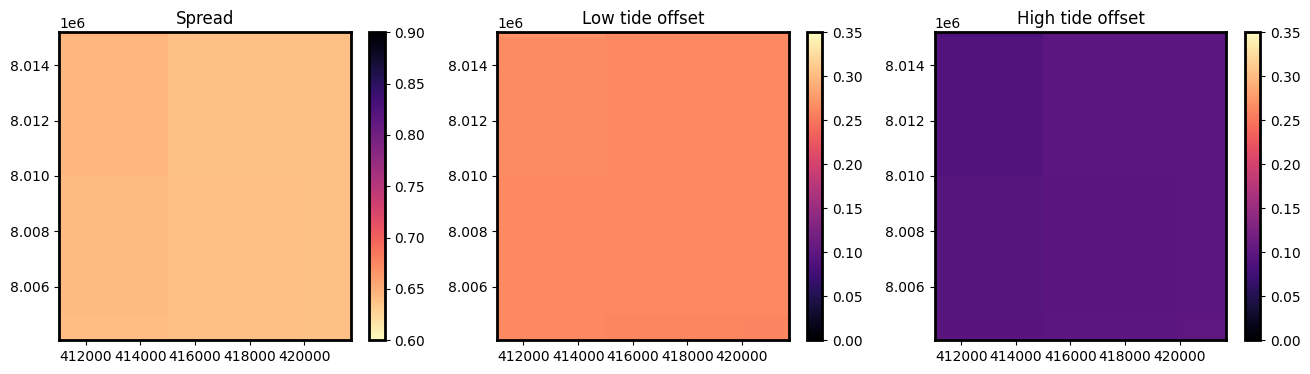

In [25]:
stats_ds = pixel_stats(ds=ds_s2, directory="../tests/data/tide_models", resample=True)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
stats_ds.spread.plot(ax=axes[0], vmin=0.6, vmax=0.9, cmap="magma_r", add_labels=False)
stats_ds.offset_low.plot(ax=axes[1], vmin=0, vmax=0.35, cmap="magma", add_labels=False)
stats_ds.offset_high.plot(ax=axes[2], vmin=0, vmax=0.35, cmap="magma", add_labels=False)
axes[0].set_title("Spread")
axes[1].set_title("Low tide offset")
axes[2].set_title("High tide offset")

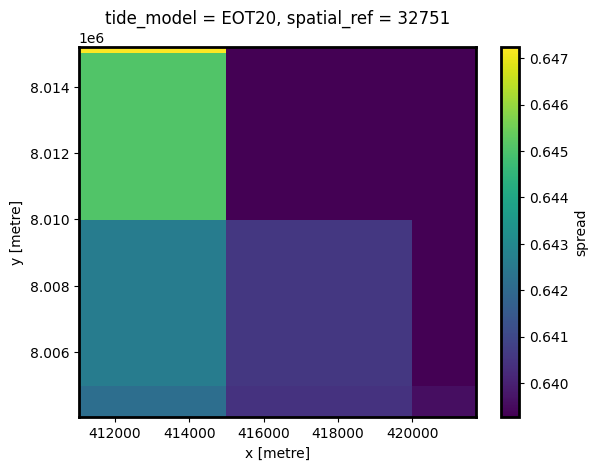

In [28]:
stats_ds.spread.plot.imshow()

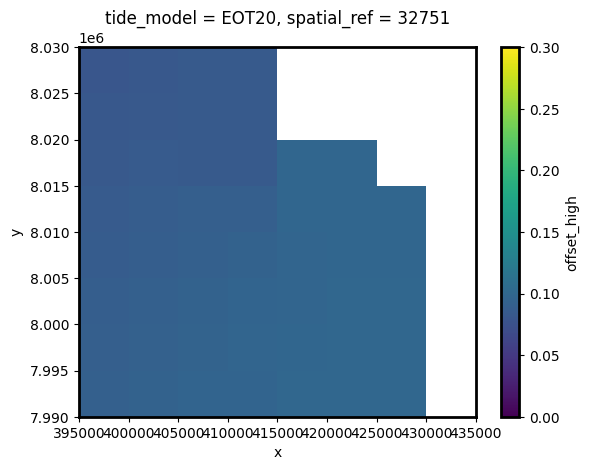

In [15]:
stats_ds.offset_high.plot(vmin=0, vmax=0.3)

In [ ]:
all_timerange

In [ ]:
import xarray as xr
import odc.geo.xr



In [ ]:
offset_high

In [ ]:
low_tide_offset